# 06 — Baroclinic Structure & Tropopause Pressure

Demonstrates the **vertical structure** of blocking events using real data:

1. Composite-mean 3-D PV anomaly at all 9 pressure levels
2. Longitude–pressure cross-sections at onset / peak / decay
3. 2-PVU dynamical tropopause pressure distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from concurrent.futures import ThreadPoolExecutor

## 1  Load composite 3-D fields

In [2]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"

def load_composite_3d(stage, dh, field="pv_anom_3d", max_events=None):
    """Compute composite mean of a 3-D field from all event NPZs."""
    sign = "+" if dh >= 0 else ""
    npz_dir = f"{DATA_ROOT}/blocking_tmp/{stage}/dh={sign}{dh}"
    files = sorted(glob.glob(os.path.join(npz_dir, "track_*.npz")))
    if max_events:
        files = files[:max_events]

    def _load(f):
        return np.load(f)[field]

    with ThreadPoolExecutor(max_workers=8) as pool:
        arrs = list(pool.map(_load, files))

    return np.mean(arrs, axis=0), len(arrs)

# Load for three lifecycle stages at dh=0
stages = ["onset", "peak", "decay"]
composites = {}
for stg in stages:
    composites[stg], n = load_composite_3d(stg, dh=0, field="pv_anom_3d")
    print(f"  {stg:6s}: {n} events, shape {composites[stg].shape}")

# Grid info from one file
d0 = dict(np.load(glob.glob(f"{DATA_ROOT}/blocking_tmp/onset/dh=+0/track_*.npz")[0]))
lat = d0["lat_vec"]
lon = d0["lon_vec_unwrapped"]
levels = d0["levels"]  # hPa
X_rel = d0["X_rel"]
Y_rel = d0["Y_rel"]

  onset : 348 events, shape (9, 29, 49)


  peak  : 337 events, shape (9, 29, 49)


  decay : 328 events, shape (9, 29, 49)


## 2  PV anomaly at each pressure level (onset)

/tmp/ipykernel_674457/3056474748.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


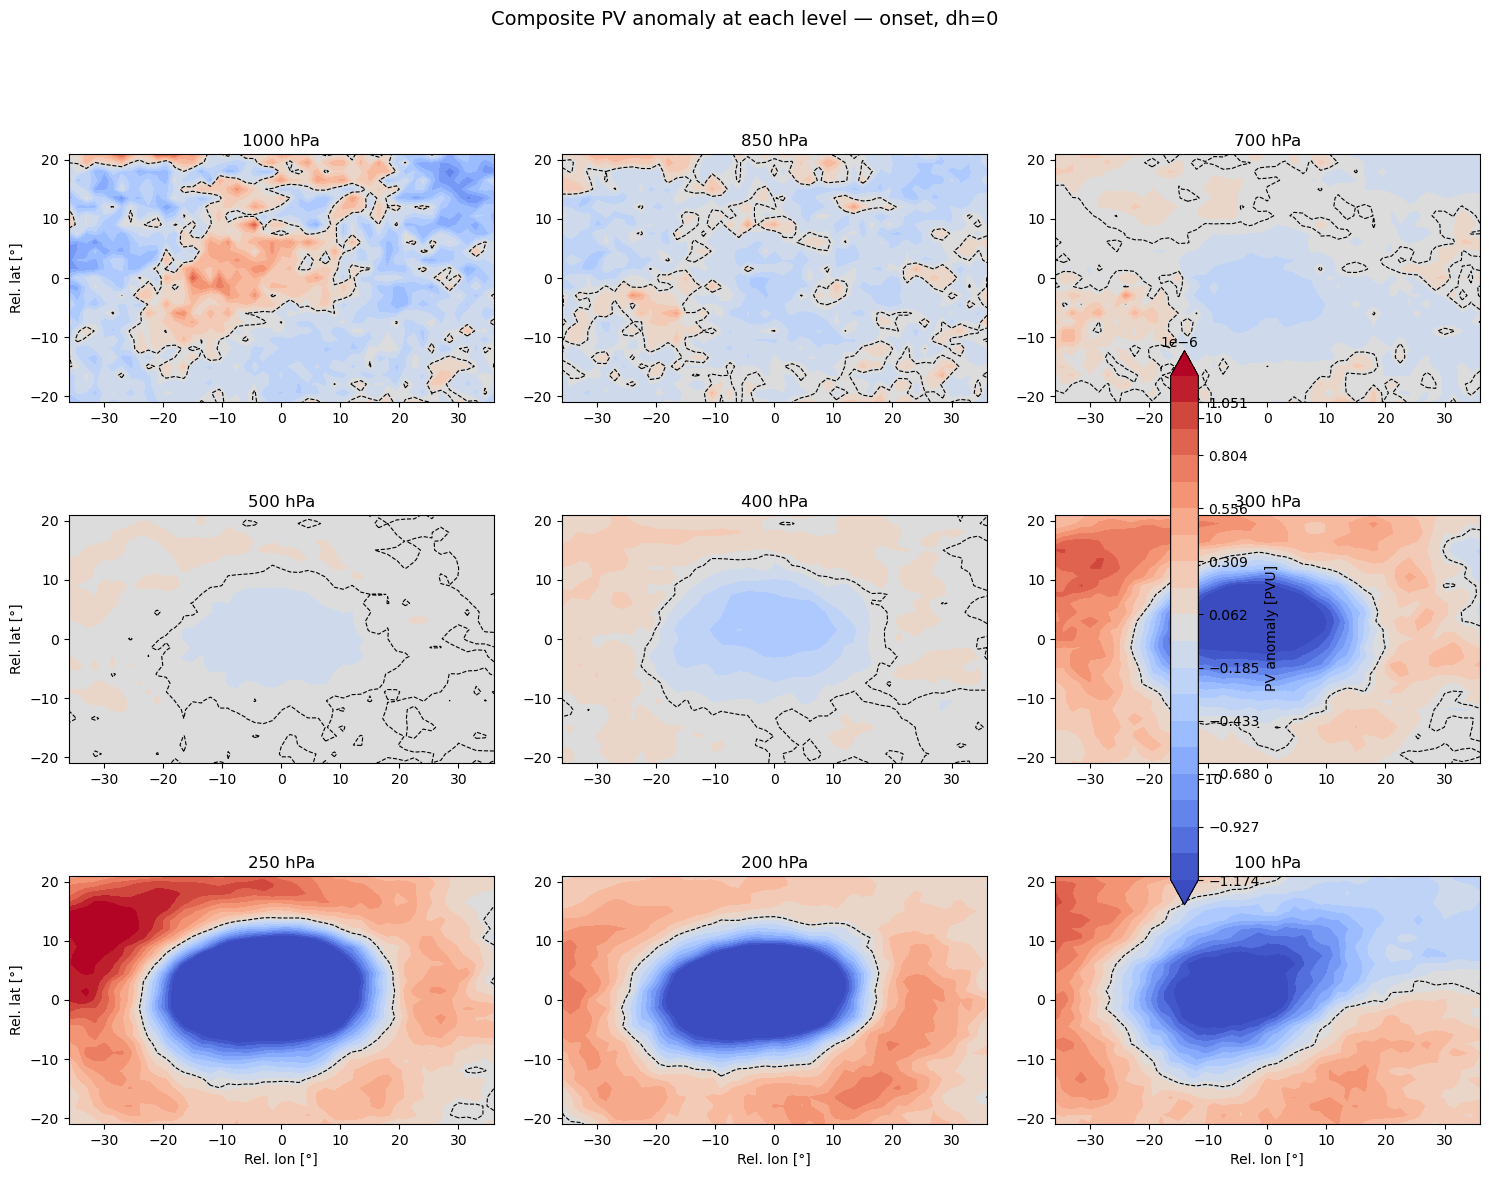

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
vmax = np.nanpercentile(np.abs(composites["onset"]), 95)

for i, ax in enumerate(axes.flat):
    cf = ax.contourf(X_rel[0], Y_rel[:, 0], composites["onset"][i],
                     levels=np.linspace(-vmax, vmax, 20), cmap="coolwarm", extend="both")
    ax.contour(X_rel[0], Y_rel[:, 0], composites["onset"][i],
              levels=[0], colors="k", linewidths=0.8, linestyles="--")
    ax.set_title(f"{levels[i]} hPa")
    ax.set_aspect("equal")
    if i % 3 == 0:
        ax.set_ylabel("Rel. lat [°]")
    if i >= 6:
        ax.set_xlabel("Rel. lon [°]")

fig.suptitle("Composite PV anomaly at each level — onset, dh=0", fontsize=14, y=1.01)
fig.colorbar(cf, ax=axes, shrink=0.6, label="PV anomaly [PVU]")
fig.tight_layout()
plt.show()

## 3  Longitude–pressure cross-sections (onset / peak / decay)

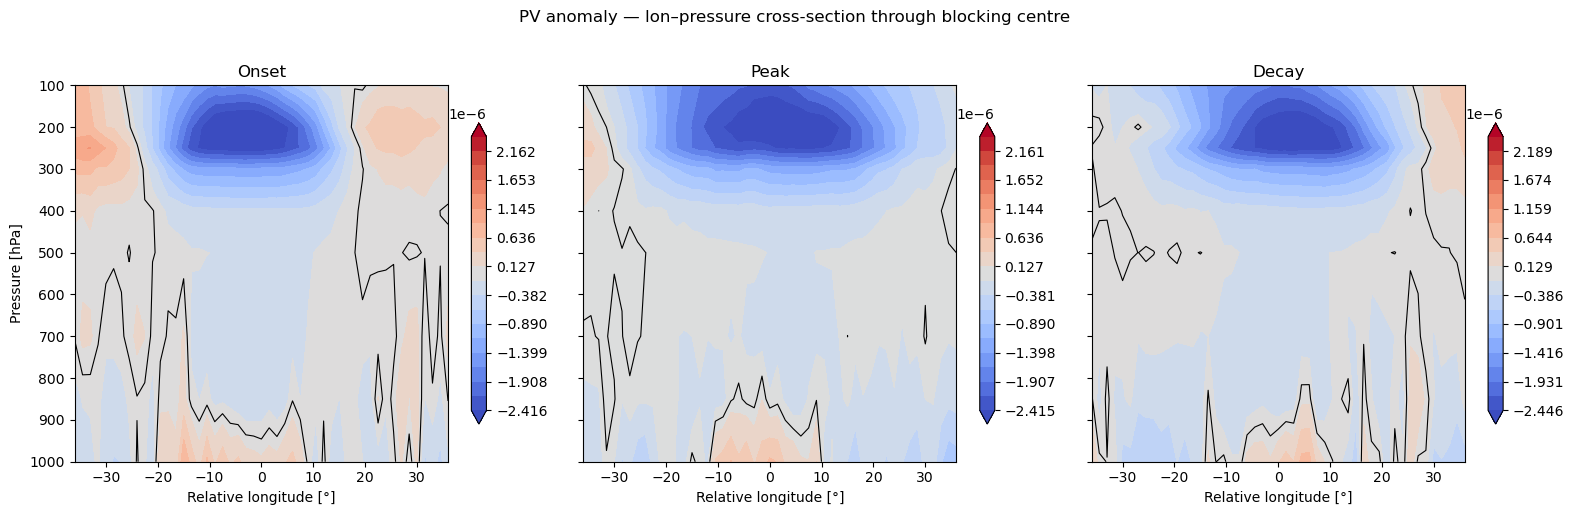

In [4]:
imid = lat.shape[0] // 2  # centre latitude row

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
for ax, stg in zip(axes, stages):
    vmax = np.nanpercentile(np.abs(composites[stg][:, imid, :]), 95)
    cf = ax.contourf(X_rel[0], levels, composites[stg][:, imid, :],
                     levels=np.linspace(-vmax, vmax, 20), cmap="coolwarm", extend="both")
    ax.contour(X_rel[0], levels, composites[stg][:, imid, :],
              levels=[0], colors="k", linewidths=0.8)
    ax.set_title(stg.capitalize())
    ax.set_xlabel("Relative longitude [°]")
    plt.colorbar(cf, ax=ax, shrink=0.8)

axes[0].set_ylabel("Pressure [hPa]")
axes[0].invert_yaxis()
fig.suptitle("PV anomaly — lon–pressure cross-section through blocking centre", y=1.02)
fig.tight_layout()
plt.show()

## 4  Dynamical tropopause pressure (2 PVU)

In [5]:
def find_2pvu_pressure(pv_3d, levels_hPa):
    """Find pressure level where PV crosses 2.0 PVU at each grid point.

    Interpolates between levels to find the 2-PVU surface.
    Returns pressure in hPa (NaN where 2 PVU is not crossed).
    """
    nlev, nlat, nlon = pv_3d.shape
    trop_p = np.full((nlat, nlon), np.nan)
    target_pv = 2.0e-6  # 2 PVU in SI units (K m² kg⁻¹ s⁻¹)

    for j in range(nlat):
        for i in range(nlon):
            col = pv_3d[:, j, i]
            # Search from surface (high p) upward (low p)
            for k in range(nlev - 1, 0, -1):
                if (col[k] <= target_pv <= col[k-1]) or (col[k] >= target_pv >= col[k-1]):
                    # Linear interpolation
                    frac = (target_pv - col[k]) / (col[k-1] - col[k] + 1e-30)
                    trop_p[j, i] = levels_hPa[k] + frac * (levels_hPa[k-1] - levels_hPa[k])
                    break
    return trop_p

# Compute 2PVU tropopause for each stage
trop_press = {}
for stg in stages:
    # Need absolute PV for tropopause, load pv_3d composite
    pv_abs, _ = load_composite_3d(stg, dh=0, field="pv_3d")
    trop_press[stg] = find_2pvu_pressure(pv_abs, levels.astype(float))
    tp = trop_press[stg]
    print(f"  {stg:6s}: trop-p range = {np.nanmin(tp):.0f} – {np.nanmax(tp):.0f} hPa, "
          f"NaN frac = {np.isnan(tp).mean():.2%}")

  onset : trop-p range = 196 – 364 hPa, NaN frac = 0.00%


  peak  : trop-p range = 226 – 367 hPa, NaN frac = 0.00%


  decay : trop-p range = 225 – 366 hPa, NaN frac = 0.00%


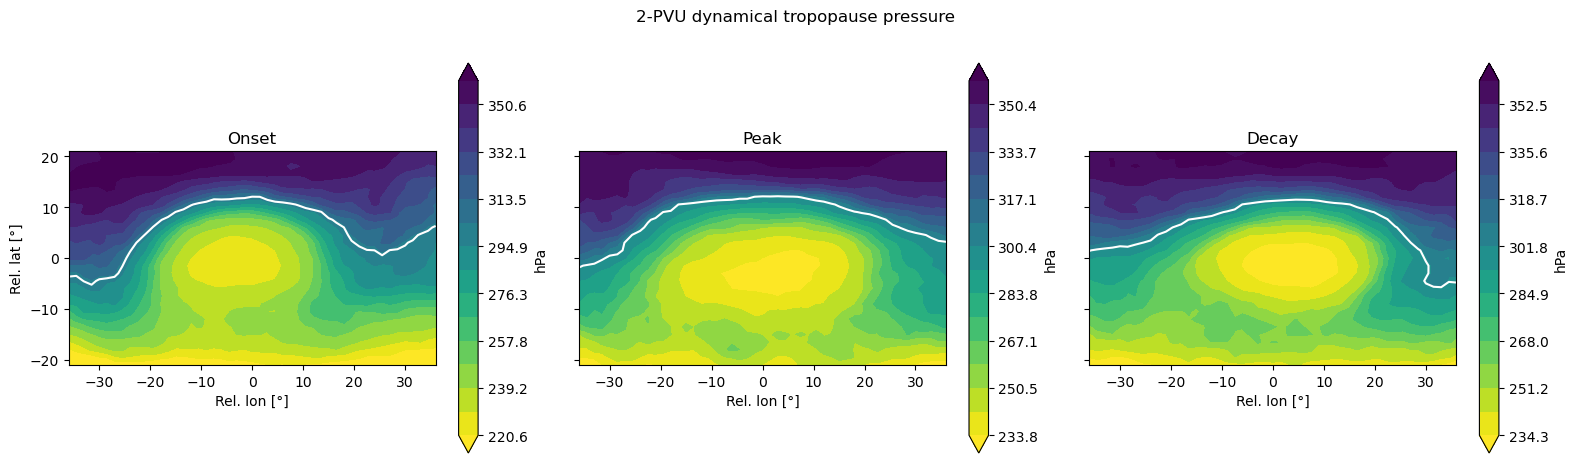

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)

for ax, stg in zip(axes, stages):
    tp = trop_press[stg]
    vmin, vmax_p = np.nanpercentile(tp, [5, 95])
    cf = ax.contourf(X_rel[0], Y_rel[:, 0], tp,
                     levels=np.linspace(vmin, vmax_p, 16), cmap="viridis_r", extend="both")
    ax.contour(X_rel[0], Y_rel[:, 0], tp,
              levels=[300], colors="white", linewidths=1.5)
    ax.set_title(f"{stg.capitalize()}")
    ax.set_aspect("equal")
    ax.set_xlabel("Rel. lon [°]")
    plt.colorbar(cf, ax=ax, label="hPa")

axes[0].set_ylabel("Rel. lat [°]")
fig.suptitle("2-PVU dynamical tropopause pressure", y=1.02)
fig.tight_layout()
plt.show()

## Summary

- The blocking PV anomaly is **strongest in the upper troposphere** (200–300 hPa)
  with a negative PV anomaly that deepens through the lifecycle.
- The **longitude–pressure cross-section** reveals the tilted, baroclinic structure
  of the blocking high, with the PV anomaly extending from 500 hPa to 100 hPa.
- The **2-PVU tropopause** is lifted (lower pressure) over the blocking centre,
  indicating the locally elevated tropopause associated with blocking.